In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
from  keras.models import Sequential, Model
from  keras.layers import Input, Dense, LeakyReLU, Activation, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, InputLayer, Flatten, BatchNormalization, Reshape, Lambda

from  keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  keras.applications.vgg16 import VGG16, preprocess_input
#from  keras.applications import ResNet152V2,ResNet101V2,ResNet50V2 
#from  keras.applications.resnet_v2 import preprocess_input 

from  keras.optimizers import RMSprop, Adam
from  keras.preprocessing.image import load_img, ImageDataGenerator
from  keras.utils import multi_gpu_model
from IPython.display import Image 

import keras_metrics
import pandas
import ast
import numpy as np
import matplotlib.patches as patches 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw

Using TensorFlow backend.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras.backend as K
import numpy as np
import random

In [4]:
BATCH_SIZE = 64
IMG_SIZE = 224

In [80]:
train_set = "./dataset/FACE_CLASSIFIER/train/"
validation_set = "./dataset/NUOVO/val/"
test_set = "./dataset/NUOVO/test/"

In [81]:
train_df = pandas.read_csv("./dataset/FACE_CLASSIFIER/train.csv")
valid_df = pandas.read_csv("./dataset/FACE_CLASSIFIER/val.csv")
test_df = pandas.read_csv("./dataset/FACE_CLASSIFIER/test.csv")

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,)
    #preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory="./",
        x_col="image_path",
        y_col="face",
        class_mode="raw",
        shuffle=True,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

valid_generator = train_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory="./",
        x_col="image_path",
        y_col="face",
        class_mode="raw",
        shuffle=True,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 33175 validated image filenames.
Found 3688 validated image filenames.


In [8]:
step_size_train = train_generator.samples/train_generator.batch_size
step_size_valid = valid_generator.samples/valid_generator.batch_size

In [97]:
darknetv1 = Sequential()
darknetv1.add(InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,3)))
#darknetv1.add(InputLayer(batch_input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,3)))
darknetv1.add(Conv2D(64,3, strides=(1,1), padding = "same"))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))
darknetv1.add(Conv2D(192,3, strides=(1,1), padding = "same"))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(128,1, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(256,3, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(GlobalAveragePooling2D())

# Da aggiungere dopo
#darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
#darknetv1.add(Conv2D(1024,3, strides=(2,2), padding = "same"))
#darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
#darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))

In [98]:
darknetv1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 112, 112, 192)     110784    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 192)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 56, 56, 128)       24704     
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 56, 56, 256)      

In [99]:
darknetv1.add(Dense(512, activation = "relu"))
darknetv1.add(Dense(512, activation = "relu"))
darknetv1.add(Dense(1, activation = "sigmoid"))

In [100]:
darknetv1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 112, 112, 192)     110784    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 192)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 56, 56, 128)       24704     
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 56, 56, 256)      

model = multi_gpu_model(model, gpus=2) #parallelize model

In [13]:
darknetv1.compile(optimizer=Adam(lr = 1e-4), loss="binary_crossentropy", metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
darknetv1.evaluate_generator(valid_generator, steps=step_size_valid, verbose = 1)


58/57 [==============================] - 14s 233ms/step


[0.6979334950447083, 0.5]

In [15]:
#earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint('darknetv1.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min')

history = darknetv1.fit_generator(generator=train_generator, epochs=20, steps_per_epoch=step_size_train, validation_data=valid_generator, validation_steps=step_size_valid, verbose=1, callbacks=[mcp_save, reduce_lr_loss])

Epoch 1/20
519/518 [==============================] - 226s 436ms/step - loss: 0.5852 - accuracy: 0.7056 - val_loss: 0.4520 - val_accuracy: 0.7893
Epoch 2/20
519/518 [==============================] - 221s 426ms/step - loss: 0.4279 - accuracy: 0.8100 - val_loss: 0.4876 - val_accuracy: 0.8300
Epoch 3/20
519/518 [==============================] - 222s 428ms/step - loss: 0.2898 - accuracy: 0.8786 - val_loss: 0.1084 - val_accuracy: 0.9124
Epoch 4/20
519/518 [==============================] - 221s 425ms/step - loss: 0.2161 - accuracy: 0.9144 - val_loss: 0.4449 - val_accuracy: 0.9100
Epoch 5/20
519/518 [==============================] - 221s 426ms/step - loss: 0.1832 - accuracy: 0.9299 - val_loss: 0.1771 - val_accuracy: 0.9317
Epoch 6/20
519/518 [==============================] - 221s 425ms/step - loss: 0.1604 - accuracy: 0.9382 - val_loss: 0.0811 - val_accuracy: 0.9531
Epoch 7/20
519/518 [==============================] - 220s 425ms/step - loss: 0.1423 - accuracy: 0.9461 - val_loss: 0.1263 -

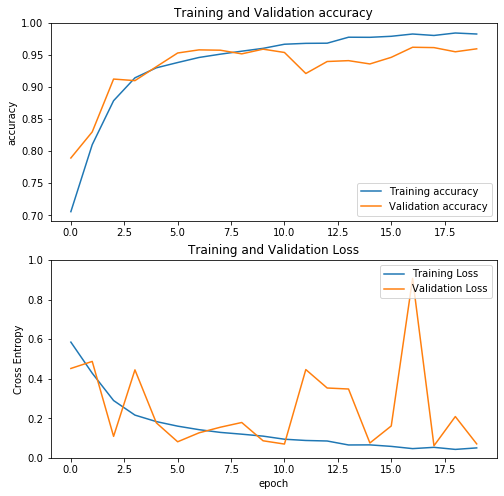

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [94]:
model_json = darknetv1.to_json()
with open("darknetv1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("resnet50.h5")
print("Saved model to disk")

Saved model to disk


# Loading model

In [102]:
darknetv2 = Sequential()
darknetv2.add(InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,3)))
#darknetv2.add(InputLayer(batch_input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,3)))
darknetv2.add(Conv2D(64,3, strides=(1,1), padding = "same"))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))
darknetv2.add(Conv2D(192,3, strides=(1,1), padding = "same"))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(128,1, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(256,3, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(GlobalAveragePooling2D())

# Da aggiungere dopo
#darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
#darknetv1.add(Conv2D(1024,3, strides=(2,2), padding = "same"))
#darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
#darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))

darknetv2.add(Dense(512, activation = "relu"))
darknetv2.add(Dense(512, activation = "relu"))
darknetv2.add(Dense(1, activation = "sigmoid"))

darknetv2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 112, 112, 192)     110784    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 56, 56, 192)       0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 56, 56, 128)       24704     
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 56, 56, 256)      

In [106]:
darknetv2.load_weights("darknetv1.h5") 
darknetv2.compile(optimizer=Adam(lr = 1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [109]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory="./",
            x_col="image_path",
            y_col="face",
            class_mode="raw",
            shuffle=False,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE)

STEP_SIZE_TEST = test_generator.n / test_generator.batch_size 


#CHANGE PARALLEL MODEL
pred=darknetv2.predict_generator(test_generator,  steps=STEP_SIZE_TEST,  verbose=1)


Found 4099 validated image filenames.
65/64 [==============================] - 10s 147ms/step


In [110]:
img = Image.open(test_generator.filenames[1])
img1 = ImageDraw.Draw(img)
font = ImageFont.truetype("arial.ttf", 50)
# get a drawing context
# draw text, half opacity
img1.text((0,0), str(pred[1]), font = font,fill=(0,0,0,0))
img.save("./dataset/FACE_CLASSIFIER/testlabel3" + ".jpg")
img.show()

In [111]:
count = 0
for el in zip(pred,test_generator.labels,test_generator.filenames):
    count = count +1
    print(count) if count % 1000 == 0 else 0
    if el[1] == 1:
        #print(el)
        img = Image.open(el[2])
        img1 = ImageDraw.Draw(img)
        font = ImageFont.truetype("arial.ttf", 50)
        # get a drawing context
        # draw text, half opacity
        img1.text((0,0), str(el[0]), font = font,fill=(0,0,0,0))
        #img.show() 
        img.save("./dataset/FACE_CLASSIFIER/results/output"+ str(count) + ".jpg")

1000
2000
3000
4000
